In [17]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings

warnings.filterwarnings('ignore')
plt.ion()

In [18]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')
n = 65
img_name = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n,1:]
landmarks = np.asanyarray(landmarks,dtype=float).reshape(-1,2)  #np.asarray() 函数用于将输入转换为 NumPy 数组,.reshape() 方法用于改变数组的形状。在这里，( -1, 2) 是新的形状参数。这里 -1 的意思是根据数组的总元素数量自动计算该维度的大小

#每个图片在csv图像中占一行，每行的第一列元素表示图像的名称，之后的每两列分别表示一个标记的坐标
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


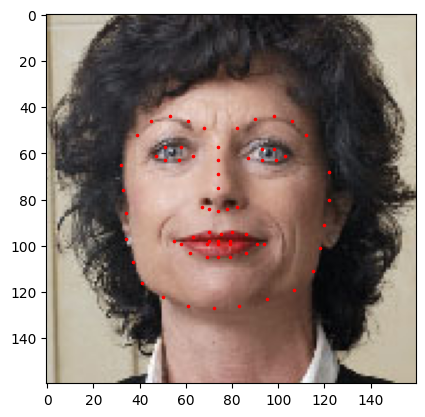

In [19]:
def show_landmarks(image, landmarks):
    """显示图片中的标记"""
    plt.imshow(image)
    plt.scatter(landmarks[:,0],landmarks[:,1],s=10,marker='.',c='r')#使用 plt.scatter() 函数在图像上绘制特征点。landmarks[:, 0] 和 landmarks[:, 1] 分别是特征点数组中所有行的第一列和第二列，这相当于将特征点的 x 坐标和 y 坐标传递给 plt.scatter()。参数 s=10 指定绘制的散点的大小为 10 像素，marker='.' 指定散点的形状为小圆点，c='r' 指定散点的颜色为红色。
    plt.pause(0.001)#在绘制完图像和特征点后暂停一小段时间，以便图表得以更新显示。这是为了避免图像显示不刷新而产生的问题。

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/',img_name)),landmarks)#io 是一个用于图像输入输出的模块，通常指的是 skimage 的 io 模块。os.path.join('data/faces/', img_name) 用于构建图像文件的完整路径，其中 'data/faces/' 是图像文件所在的目录，img_name 是图像文件的名称.io.imread(os.path.join('data/faces/',img_name)表示根据图像名称从给定地址中读取图片
plt.show()

In [20]:
class FaceLandmarkDataset(Dataset):#自己创建一个数据集类

    #重新些初始化函数，传入常用信息
    def __init__(self, csv_file, root_dir, transform=None):
        """
        information
        :param csv_file: csv文件存储路径
        :param root_dir: 图像存储路径
        :param transform: （可选的），应用在样本格式上，将每个样本转换成transform的格式
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    #重写得到数据集长度函数
    def __len__(self):
        return len(self.landmarks_frame)

    #重写取出单个样本函数
    def __getitem__(self, idx):
        if torch.is_tensor(idx):#idx可以是张量
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[idx,0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks],dtype=float).reshape(-1,2)
        sample = {'image':image, 'landmarks':landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)


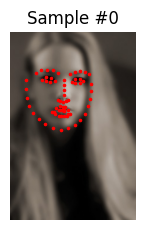

1 (500, 333, 3) (68, 2)


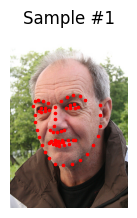

2 (250, 258, 3) (68, 2)


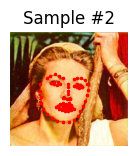

3 (434, 290, 3) (68, 2)


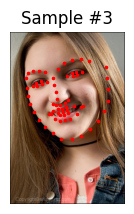

In [21]:
face_dataset = FaceLandmarkDataset(csv_file='data/faces/face_landmarks.csv',root_dir='data/faces/')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i,sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i==3:
        plt.show()
        break

In [22]:
class Rescale(object):
    """
    将图片按照给定比例缩放
    """
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        self.output_size = output_size

    def __call__(self, sample):
        #将图像大小和标记坐标缩放
        image, landmarks = sample['image'], sample['landmarks']

        h,w = image.shape[:2]
        if isinstance(self.output_size,int):
            if h>w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}
class RandomCrop(object):

    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size,output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0,h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h, left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image':image,'landmarks':landmarks}

class ToTensor(object):
    """
    将样本中的数据转换成tensor格式
    """
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']

        image = image.transpose((2, 0, 1))
        return {'image':torch.from_numpy(image),'landmarks':torch.from_numpy(landmarks)}


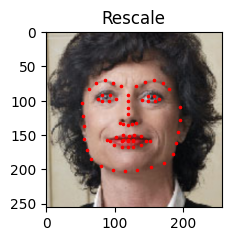

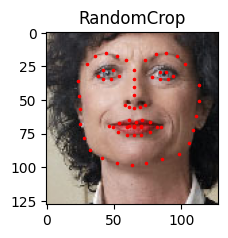

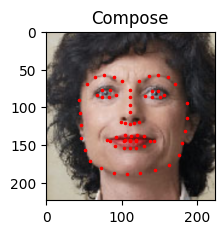

In [23]:
#torchvision.transforms.Compose类可以将缩放和裁剪合并
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [24]:
#运用随机裁剪，缩放，以及组合来变换原始图像
transformed_dataset = FaceLandmarkDataset(csv_file='data/faces/face_landmarks.csv',root_dir='data/faces/',transform=transforms.Compose([Rescale(256),RandomCrop(224),ToTensor()]))

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


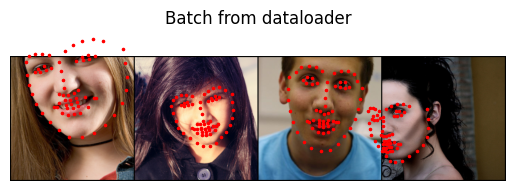

In [25]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)

def show_landmarks_batch(sample_batched):
    """分批展示图像"""
    images_batch, landmarks_batch = sample_batched['image'],sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size, landmarks_batch[i, :, 1].numpy() + grid_border_size, s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break